In [1]:
import numpy as np
import keras
import scipy.io as sio
import pandas as pd
import tensorflow as tf
from sklearn import model_selection
import matplotlib.pyplot as plt 
from keras import layers
#from keras.models import Sequential
from keras.models import model_from_json
#from livelossplot.keras import PlotLossesCallback
from IPython.display import clear_output
from keras.utils.vis_utils import plot_model
#from sklearn import preprocessing
#import math

from skimage import feature
from skimage.filters import gaussian

In [2]:
keras.backend.clear_session()

In [3]:
filename = '../../data/raw/MarmousiModel2.mat'
marmousi_cube = sio.loadmat(filename)

### Carregar dados e cubos de Sísmica e Impedância

In [4]:
VP = marmousi_cube['Vp']
#VS = marmousi_cube['Vs']
#IS = marmousi_cube['IS']
pimpedance = marmousi_cube['IP']
seismic = marmousi_cube['seismic']

WAVELET = marmousi_cube['wavelet']

### Parameters 

In [5]:
n_traces = pimpedance.shape[1]

train_wells_loc = np.arange(0,n_traces,135)
all_wells_loc = np.arange(n_traces)

wells_loc = np.array(list(set(all_wells_loc) - set(train_wells_loc)))
valid_wells_loc, unlabed_wells_loc = model_selection.train_test_split(wells_loc,
                                                                      test_size=0.9,
                                                                      train_size=0.1,
                                                                      shuffle=True)
BATCH_SIZE = 10
N_EPOCHS = 2000
noise_dim = 2800
IMG_SHAPE = (2800,1,1)

### Normalizar Sismica

In [6]:
seismic_norm = seismic.flatten()
ymin = 0
ymax = 1
seismic_norm = (ymax-ymin)*(seismic_norm-np.min(seismic_norm))/(np.max(seismic_norm)-np.min(seismic_norm)) + ymin
seismic_norm = seismic_norm.reshape(seismic.shape)
#seismic_norm = seismic

In [7]:
pimpedance_norm = pimpedance.flatten()
ymin = 0
ymax = 1
pimpedance_norm = (ymax-ymin)*(pimpedance_norm-np.min(pimpedance_norm))/(np.max(pimpedance_norm)-np.min(pimpedance_norm)) + ymin
pimpedance = pimpedance_norm.reshape(pimpedance.shape)
#seismic_norm = seismic

### Visualizar estatísticas

In [8]:
'''data_info = pd.DataFrame(zip(seismic_norm.flatten(),
                             pimpedance.flatten()),
                         columns=['Seismic CL Stats','PImp CL Stats'])
data_info.describe()'''

"data_info = pd.DataFrame(zip(seismic_norm.flatten(),\n                             pimpedance.flatten()),\n                         columns=['Seismic CL Stats','PImp CL Stats'])\ndata_info.describe()"

### Preparar os Dados

In [9]:
X_train = np.transpose(seismic_norm[:,train_wells_loc])
Y_train = np.transpose(pimpedance[:-1,train_wells_loc])
X_train = np.expand_dims(X_train,axis=(2,3))
Y_train = np.expand_dims(Y_train,axis=(2,3))

X_valid = np.transpose(seismic_norm[:,valid_wells_loc])
Y_valid = np.transpose(pimpedance[:-1,valid_wells_loc])
X_valid = np.expand_dims(X_valid,axis=(2,3))
Y_valid = np.expand_dims(Y_valid,axis=(2,3))

X_test = np.transpose(seismic_norm)
Y_test = np.transpose(pimpedance[:-1,:])
X_test = np.expand_dims(X_test,axis=(2,3))
Y_test = np.expand_dims(Y_test,axis=(2,3))

UNLABED_SEISMIC = np.transpose(seismic_norm[:,unlabed_wells_loc])
UNLABED_SEISMIC = np.expand_dims(UNLABED_SEISMIC,axis=(2,3))

In [10]:
print('     IP (Y_train) shape: ',Y_train.shape)
print('seismic (X_train) shape: ',X_train.shape)

print('     IP (Y_valid) shape: ',Y_valid.shape)
print('seismic (X_valid) shape: ',X_valid.shape)

print('     IP (Y_test) shape: ',Y_test.shape)
print('seismic (X_test) shape: ',X_test.shape)

     IP (Y_train) shape:  (101, 2800, 1, 1)
seismic (X_train) shape:  (101, 2800, 1, 1)
     IP (Y_valid) shape:  (1350, 2800, 1, 1)
seismic (X_valid) shape:  (1350, 2800, 1, 1)
     IP (Y_test) shape:  (13601, 2800, 1, 1)
seismic (X_test) shape:  (13601, 2800, 1, 1)


### Visualizar Dados

Text(0.5, 1.0, 'Output P-Impedance Test - Ground True')

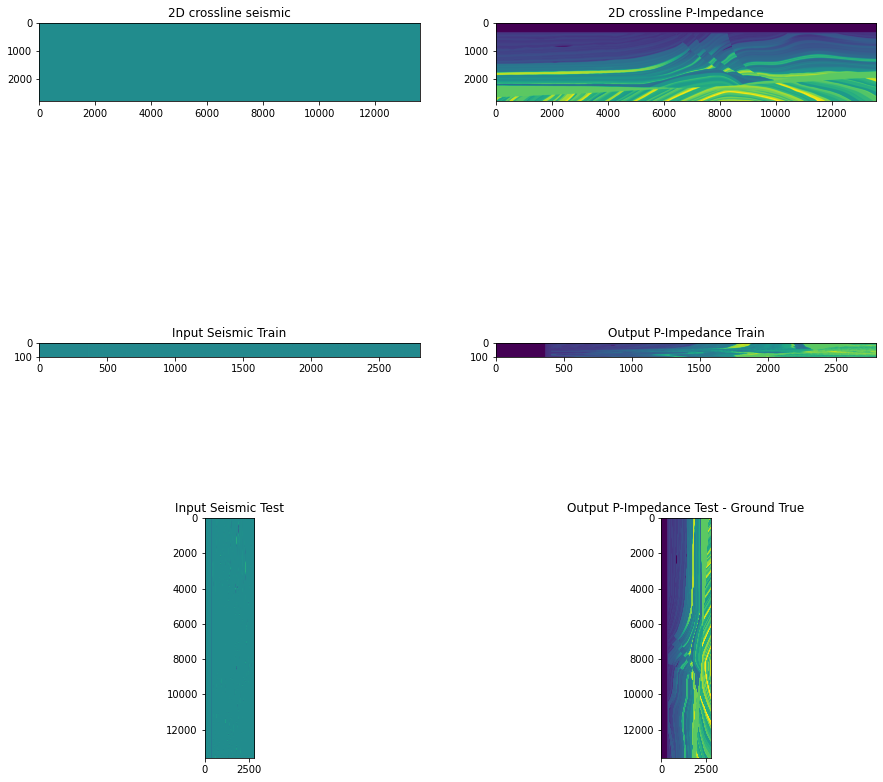

In [11]:
fig1, axes1 = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

axes1[0,0].imshow(seismic)
axes1[0,0].set_title("2D crossline seismic")

axes1[0,1].imshow(pimpedance)
axes1[0,1].set_title("2D crossline P-Impedance")

axes1[1,0].imshow(X_train[:,:,0,0])
axes1[1,0].set_title("Input Seismic Train")

axes1[1,1].imshow(Y_train[:,:,0,0])
axes1[1,1].set_title("Output P-Impedance Train")

axes1[2,0].imshow(X_test[:,:,0,0])
axes1[2,0].set_title("Input Seismic Test")
axes1[2,1].imshow(Y_test[:,:,0,0])
axes1[2,1].set_title("Output P-Impedance Test - Ground True")

## Create and Train Inversion GAN

### Load Forward Model

In [12]:
# load json and create model
json_file = open('forward_model/modelnorm_2d.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
forward_model = model_from_json(loaded_model_json)
# load weights into new model
forward_model.load_weights("forward_model/modelnorm_2d.h5")
print("Loaded forward model from disk")

Loaded forward model from disk


In [13]:
test_forward = False
if test_forward:
    predict = forward_model(Y_test[:6000,:])
    predict = np.transpose(predict[:,:,0].numpy())

In [14]:
if test_forward:
    trace_id = np.random.randint(predict.shape[1])
    plt.plot(predict[0,:,trace_id])
    plt.plot(X_test[trace_id,:,0])
    plt.show()

### Create the generator


In [15]:
def get_generator_model():
    noise = layers.Input(shape=(noise_dim,1,1))

    GEN = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(noise)
    GEN = layers.BatchNormalization()(noise)
    GEN = layers.ReLU()(GEN)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
        
    GEN = layers.Conv2D(filters=1,kernel_size=(3,1),strides=(1,1),padding='same')(GEN)

    GENmodel = keras.models.Model(inputs=noise,outputs=GEN)
    return GENmodel

### Create the discriminator (the critic in the original WGAN)

In [16]:
def get_discriminator_model():       
    input_disc = layers.Input(shape=IMG_SHAPE)        
    ENC = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same',strides=2)(input_disc)
    ENC = layers.LeakyReLU()(ENC)
    ENC = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENC)
        
    ENCB1 = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(ENC)
    ENCB1 = layers.ReLU()(ENCB1)
    ENCB1 = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(ENCB1)
    ENCB1 = layers.Add()([ENCB1, ENC])
    ENCB1 = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENCB1)
    ENCB1 = layers.ReLU()(ENCB1)
        
    ENCB2 = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(ENCB1)
    ENCB2 = layers.ReLU()(ENCB2)
    ENCB2 = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(ENCB2)
    ENCB2 = layers.Add()([ENCB2, ENCB1])
    ENCB2 = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENCB2)
    ENCB2 = layers.ReLU()(ENCB1)
        
    ENCB3 = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(ENCB2)
    ENCB3 = layers.ReLU()(ENCB3)
    ENCB3 = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(ENCB3)
    ENCB3 = layers.Add()([ENCB2, ENCB3])
    ENCB3 = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENCB3)
    ENCB3 = layers.ReLU()(ENCB3)
        
    r1 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=1)(ENCB3)
    r1 = layers.BatchNormalization()(r1)
    r1 = layers.ReLU()(r1)
    r2 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=3)(ENCB3)
    r2 = layers.BatchNormalization()(r2)
    r2 = layers.ReLU()(r2)
    r3 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=5)(ENCB3)
    r3 = layers.BatchNormalization()(r3)
    r3 = layers.ReLU()(r3)
    r4 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=7)(ENCB3)
    r4 = layers.BatchNormalization()(r4)
    r4 = layers.ReLU()(r4)
    assp = layers.concatenate([r1,r2,r3,r4])
    assp = layers.Conv2D(filters=64,kernel_size=(3,1),padding='same',strides=2)(assp)
        
        
    fc_out = layers.Dense(256,kernel_initializer=tf.keras.initializers.HeNormal())(assp)
    lkr_out = layers.LeakyReLU()(fc_out)
    fc2_outFlatten = layers.Flatten()(lkr_out)
    fc2_out = layers.Dense(1,kernel_initializer=tf.keras.initializers.HeNormal())(fc2_outFlatten)
        
    DISCmodel = keras.models.Model(inputs=input_disc,outputs=fc2_out)
    return DISCmodel

### Create the WGAN-GP models

In [17]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
        alpha_weight = 1000,
        beta_weight = 500
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight
        self.alpha_weight = alpha_weight
        self.beta_weight = beta_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn, imp_loss_fn, seis_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.imp_loss_fn = imp_loss_fn
        self.seis_loss_fn = seis_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        
        alpha = tf.random.normal([batch_size, 1, 1,1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
       
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        noises_input,real_images = data
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        random_latent_vectors = noises_input
        
        for i in range(self.d_steps):

            with tf.GradientTape() as tape:
                
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)

                real_logits = self.discriminator(real_images, training=True)

                # discriminator loss
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                
                # gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                
                d_loss = d_cost + gp * self.gp_weight 
            
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))
        
        # Unlabed seismic mini-batch:
        unlabed_wells_loc = np.arange(UNLABED_SEISMIC.shape[1])
        np.random.shuffle(unlabed_wells_loc)
        unlabed_batch_idxs = unlabed_wells_loc[0:BATCH_SIZE]
        unlabed_batch = UNLABED_SEISMIC[unlabed_batch_idxs,:,:,:]
        
        with tf.GradientTape() as tape:
            
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            
            #Generator loss
            g_cost = self.g_loss_fn(gen_img_logits)
            
            #Impedance loss
            imp_loss = self.imp_loss_fn(generated_images, real_images)
                        
            #Seismic loss:
            fake_seis_unlabed = forward_model(self.generator(unlabed_batch,training=True))
            seis_cost = self.seis_loss_fn(fake_seis_unlabed,unlabed_batch)
            
            g_loss = g_cost + self.alpha_weight * imp_loss + self.beta_weight * seis_cost
            
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        
        return {"d_loss": d_loss, "g_loss": g_loss,"imp_loss":(self.alpha_weight * imp_loss),"seis_loss":(self.beta_weight * seis_cost)}

### CallBacks

In [18]:
checkp_callback = keras.callbacks.ModelCheckpoint(filepath='best_model.hdf5',
                                             monitor='imp_loss',
                                             verbose=2,
                                             save_best_only=True,
                                             mode='min')

earlystop_callback =  tf.keras.callbacks.EarlyStopping(monitor='imp_loss', 
            mode='min',
            restore_best_weights=True, 
            verbose=2, 
            patience=600)

nan_callback = tf.keras.callbacks.TerminateOnNaN()

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.d_losses = []
        self.g_losses = []
        self.imp_losses = []
        self.seis_losses =[]
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.d_losses.append(logs.get('d_loss'))
        self.g_losses.append(logs.get('g_loss'))
        self.imp_losses.append(logs.get('imp_loss'))
        self.seis_losses.append(logs.get('seis_loss'))
        self.i += 1
        
        clear_output(wait=True) 
        if self.i>50:
            plt.plot(self.x[-100:], self.d_losses[-100:], label="d_loss")
            plt.plot(self.x[-100:], self.g_losses[-100:], label="g_loss")
            plt.plot(self.x[-100:], self.imp_losses[-100:], label="imp_loss")
            plt.plot(self.x[-100:], self.seis_losses[-100:], label="seis_loss")
        else:
            plt.plot(self.x, self.d_losses, label="d_loss")
            plt.plot(self.x, self.g_losses, label="g_loss")
            plt.plot(self.x, self.imp_losses, label="imp_loss")
            plt.plot(self.x, self.seis_losses, label="seis_loss")
        plt.legend()
        plt.show();
        
plot_callback = PlotLosses()

### Train the end-to-end model

In [27]:
#Initialize internal models: 
g_model = get_generator_model()
d_model = get_discriminator_model()

#optimizers:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer = keras.optimizers.Adam(learning_rate = 0.001)

# All needed losses:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

def impedance_loss(fake_imp,real_imp):
    imp_mse = tf.keras.metrics.mean_squared_error(real_imp, fake_imp)
    return imp_mse

def seismic_loss(fake_seis,real_seis):
    seis_loss = tf.keras.metrics.mean_squared_error(real_seis, fake_seis)
    return seis_loss


wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=5,
    alpha_weight = 1000,
    beta_weight = 500,
    gp_weight = 10
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
    imp_loss_fn = impedance_loss,
    seis_loss_fn = seismic_loss
)

In [20]:
# Initialize model training:
wgan.fit(X_train,Y_train,
         shuffle=True,
         batch_size=BATCH_SIZE, 
         epochs=N_EPOCHS, 
         verbose = 1,
         #callbacks=[checkp_callback]
        )

Epoch 1/2000
11/11 [==============================] - 31s 403ms/step - d_loss: -123.5476 - g_loss: 2386.7017 - imp_loss: 2292.1602 - seis_loss: 22.8273
Epoch 2/2000
11/11 [==============================] - 4s 318ms/step - d_loss: -33.0465 - g_loss: 193.0845 - imp_loss: 157.2377 - seis_loss: 3.8817
Epoch 3/2000
11/11 [==============================] - 4s 318ms/step - d_loss: -39.3914 - g_loss: 148.6065 - imp_loss: 98.5566 - seis_loss: 2.1531
Epoch 4/2000
11/11 [==============================] - 4s 318ms/step - d_loss: -13.7066 - g_loss: 117.4083 - imp_loss: 80.2248 - seis_loss: 1.0202
Epoch 5/2000
11/11 [==============================] - 4s 321ms/step - d_loss: -19.1768 - g_loss: 103.7801 - imp_loss: 60.8843 - seis_loss: 0.8512
Epoch 6/2000
11/11 [==============================] - 4s 320ms/step - d_loss: -14.6322 - g_loss: 100.2662 - imp_loss: 56.6008 - seis_loss: 0.7533
Epoch 7/2000
11/11 [==============================] - 4s 318ms/step - d_loss: -19.2661 - g_loss: 96.3521 - imp_loss: 

In [21]:
X_predict = np.zeros(Y_test.shape[0:2])
for i in range(round((X_predict.shape[0])/1000)):
    start_,stop_ = (i*1000),(i+1)*1000
    if start_ >= X_predict.shape[0]:
        start_ = X_predict.shape[0]
    if stop_ >= X_predict.shape[0]:
        stop_ = X_predict.shape[0]    
        
    X_predict[start_:stop_,:] = wgan.generator(X_test[start_:stop_,:,:,:])[:,:,0,0]
X_predict = np.transpose(X_predict)

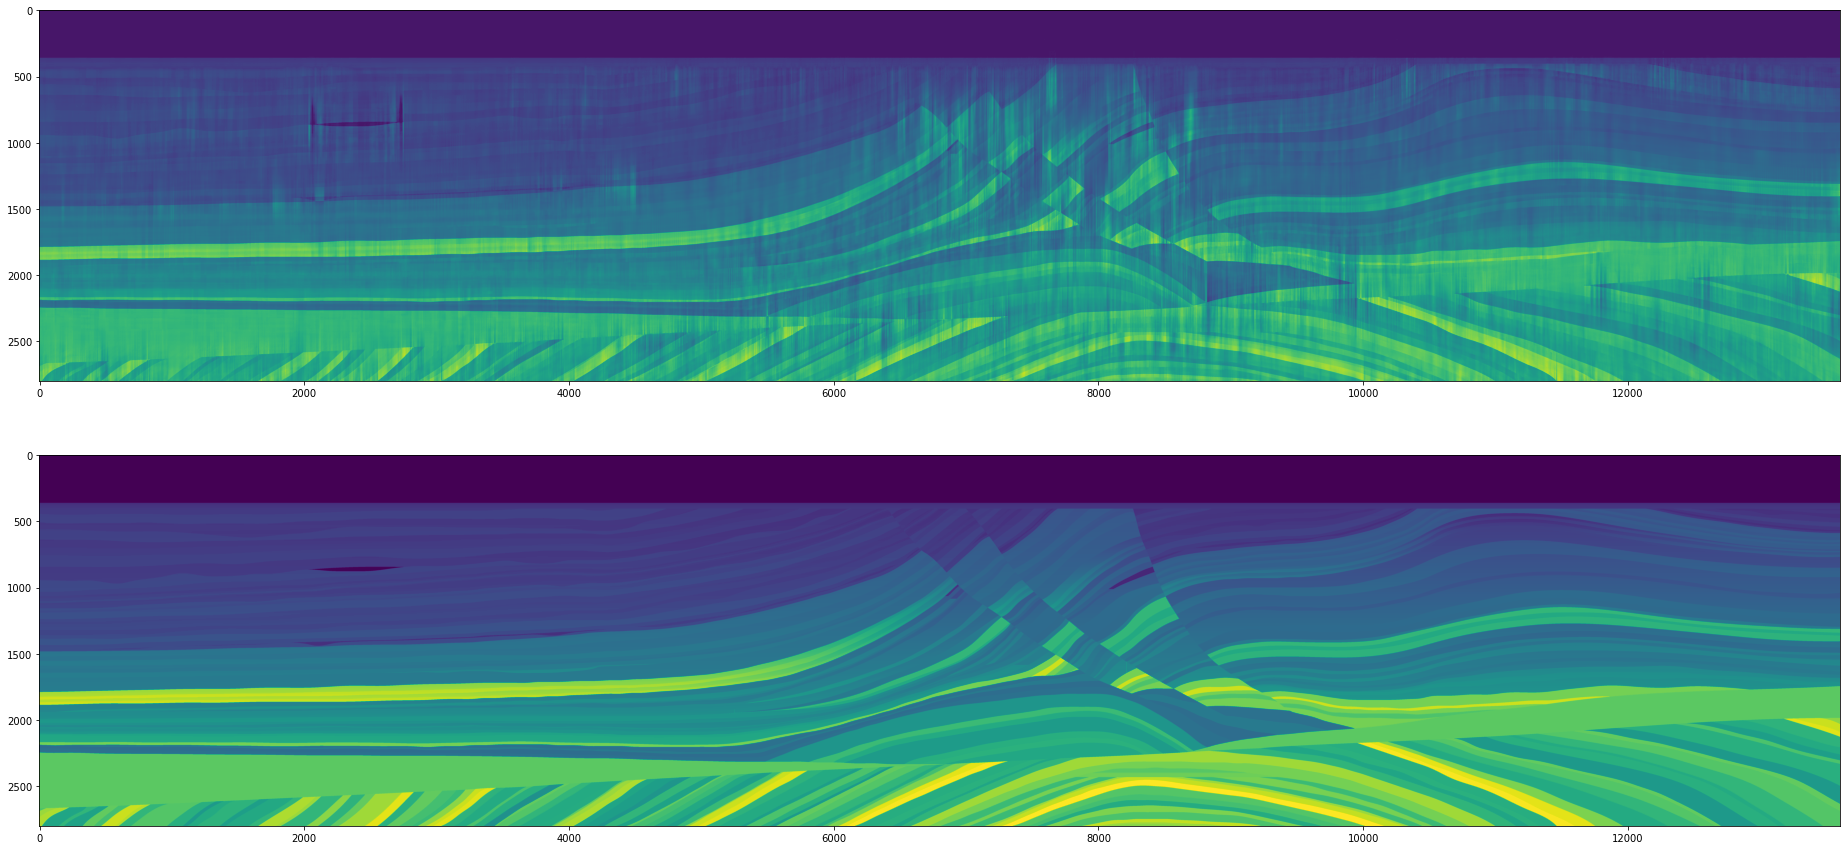

In [22]:
fig1, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(50,15))
axes1[0].imshow(X_predict)
axes1[1].imshow(np.transpose(Y_test[:,:,0,0]))

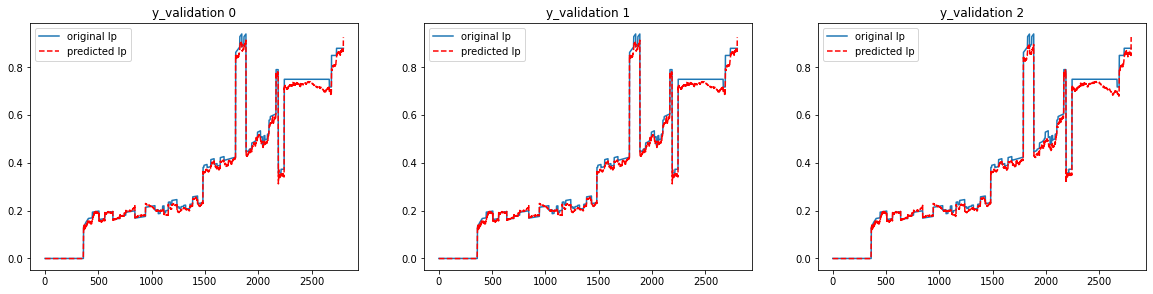

In [23]:
# trace_id = np.random.randint(X_predict.shape[1])
# plt.plot(X_predict[:,trace_id])
# plt.plot(Y_test[trace_id,:,0])
# plt.legend(('predicted','target'))
# plt.title('Trace No.: '+str(trace_id))

test_imp = Y_test[:,:,0,0].T

n = 3
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    ax.set_title("y_validation {0}".format(i-1))
    plt.plot(test_imp[:,i-1])
    plt.plot(X_predict[:, i-1], '--r')
    plt.legend(['original Ip', 'predicted Ip'])
plt.show()

SSIM:  0.7931516
SSIM Multiscale:  0.8851539


Text(0.5, 1.0, 'Target')

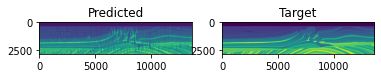

In [24]:
original_shape = np.expand_dims(X_predict, axis=2)

predict_image = np.expand_dims(X_predict, axis=2)
predict_image = (predict_image-np.min(predict_image))/(np.max(predict_image)-np.min(predict_image))
predict_image = predict_image.reshape(original_shape.shape)
predict_image = (predict_image).astype('float32')

target_image = np.expand_dims(test_imp, axis=2)
target_image = (target_image-np.min(target_image))/(np.max(target_image)-np.min(target_image))
target_image = target_image.reshape(original_shape.shape)
target_image = target_image.astype('float32')

SSIM = tf.image.ssim(target_image, predict_image, max_val=1).numpy()
MSSIM = tf.image.ssim_multiscale(target_image, predict_image, max_val=1, power_factors=(0.0448, 0.2856, 0.3001, 0.2363)).numpy()
print('SSIM: ', SSIM)
print('SSIM Multiscale: ', MSSIM)

fig1, axes1 = plt.subplots(nrows=1, ncols=2)
axes1[0].imshow(predict_image[:,:,0])
axes1[0].set_title("Predicted")
axes1[1].imshow(target_image[:,:,0])
axes1[1].set_title("Target")

In [25]:
# target_image = Y_test[:,:,0,0].T
# predict_image = X_predict[:,:]

# mse_res = tf.keras.metrics.mean_squared_error(target_image.flatten(), predict_image.flatten()).numpy()
# mae_res = tf.keras.metrics.mean_absolute_error(target_image.flatten(), predict_image.flatten()).numpy()

# m = tf.keras.metrics.RootMeanSquaredError()
# m.update_state(target_image.flatten(), predict_image.flatten())

# print("MSE: ", mse_res)
# print("MAE: ", mae_res)
# print("RMSE: ", m.result().numpy())

mse_res = tf.keras.metrics.mean_squared_error(target_image.flatten(), predict_image.flatten()).numpy()
mae_res = tf.keras.metrics.mean_absolute_error(target_image.flatten(), predict_image.flatten()).numpy()

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(target_image.flatten(), predict_image.flatten())

print(f"MSE: ", mse_res)
print("MAE: ", mae_res)
print("RMSE: ", m.result().numpy())

MSE:  0.005683249
MAE:  0.05801004
RMSE:  0.07538733


In [26]:
def soft_F_measure(target_data,
                   predicted_data,
                   canny_sigma=3,
                   gaussian_sigma=1,
                   beta_F1=1,
                   plot_data=True):
    e = feature.canny(target_data, sigma=canny_sigma)
    e_ = feature.canny(predicted_data, sigma=canny_sigma)

    e_ = gaussian(e_,sigma=gaussian_sigma,multichannel=None, preserve_range=True)
    #e_ = e_/np.max(e_.flatten())-np.min(e_.flatten())

    TP = np.minimum(e,e_)
    TN = np.minimum(1-e,1-e_)
    FP = np.maximum(e_ - e , np.zeros(e.shape))
    FN = np.maximum(e - e_ , np.zeros(e.shape))
    sTP = np.sum(TP.flatten())
    sTN = np.sum(TN.flatten())
    sFP = np.sum(FP.flatten())
    sFN = np.sum(FN.flatten())
    
    soft_precision = sTP/(sTP+sFP)
    soft_recall = sTP/(sTP+sFN)
    
    soft_FM = (1+beta_F1**2)*(soft_precision*soft_recall)/(soft_precision*(beta_F1**2)+soft_recall)
    if plot_data:
    
        fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(16, 8))
        ax[0,0].imshow(target_data)
        ax[0,0].set_title('ground truth')

        ax[1,0].imshow(e, cmap='gray')
        ax[1,0].set_title('ground truth, canny, sigma:{}'.format(canny_sigma))

        ax[0,1].imshow(predicted_data)
        ax[0,1].set_title('predicted')

        ax[1,1].imshow(e_, cmap='gray')
        ax[1,1].set_title('predicted, canny, sigma:{}'.format(canny_sigma))
        
        ax[0,2].imshow(TP)
        ax[0,2].set_title('True Positive')

        ax[1,2].imshow(TN)
        ax[1,2].set_title('True Negative')

        ax[0,3].imshow(FP)
        ax[0,3].set_title('False Positive'.format(canny_sigma))

        ax[1,3].imshow(FN)
        ax[1,3].set_title('False Negative'.format(canny_sigma))

        fig.tight_layout()
        plt.show()
        
    return soft_FM

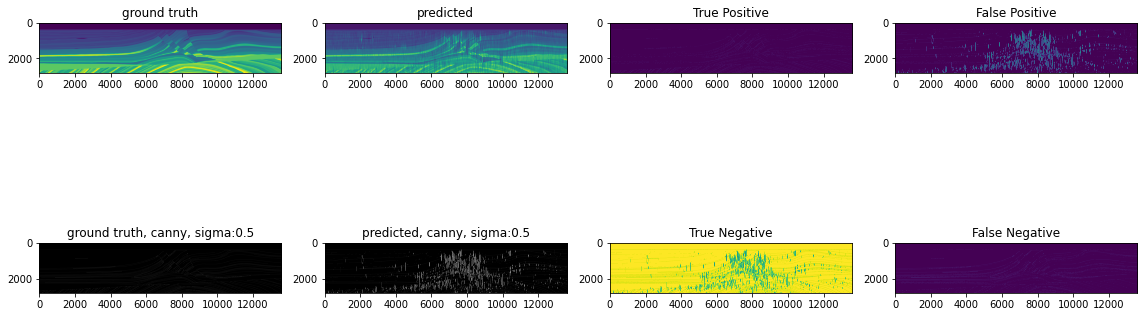

0.18034767718665165


In [28]:
# plt.imshow(Y_test[:,:,0,0].T)
# print(Y_test[:,:,0,0].T.shape)
# print(X_predict.shape)

Fb = soft_F_measure(target_data=Y_test[:,:,0,0].T,
                    predicted_data=X_predict[:,:],                 
                    canny_sigma=0.5,
                    gaussian_sigma=0.5,
                    beta_F1=1,
                    plot_data=True)

print(Fb)

## Train baseline: CNN = generator

In [27]:
cnn_inversion = get_generator_model()

optimizer_cnn = keras.optimizers.Adam(learning_rate = 0.001)

cnn_inversion.compile(optimizer=optimizer_cnn, loss='mse', metrics='mse')

In [28]:
cnn_inversion.fit(X_train,Y_train, 
            validation_data=(X_valid,Y_valid),
            epochs=N_EPOCHS,
            verbose=1,
            shuffle=True,
            batch_size=BATCH_SIZE,
           # callbacks = [plot_losses,checkpoint]
           )

Epoch 1/2000
11/11 [==============================] - 3s 201ms/step - loss: 0.8784 - mse: 0.8784 - val_loss: 0.2064 - val_mse: 0.2064
Epoch 2/2000
11/11 [==============================] - 1s 113ms/step - loss: 0.1121 - mse: 0.1121 - val_loss: 0.1673 - val_mse: 0.1673
Epoch 3/2000
11/11 [==============================] - 1s 114ms/step - loss: 0.0661 - mse: 0.0661 - val_loss: 0.1218 - val_mse: 0.1218
Epoch 4/2000
11/11 [==============================] - 1s 114ms/step - loss: 0.0526 - mse: 0.0526 - val_loss: 0.1178 - val_mse: 0.1178
Epoch 5/2000
11/11 [==============================] - 1s 113ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.1222 - val_mse: 0.1222
Epoch 6/2000
11/11 [==============================] - 1s 112ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.1297 - val_mse: 0.1297
Epoch 7/2000
11/11 [==============================] - 1s 115ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.1267 - val_mse: 0.1267
Epoch 8/2000
11/11 [==============================] - 1s 116ms

In [29]:
X_predictCNN = np.zeros(Y_test.shape[0:2])
for i in range(round((X_predictCNN.shape[0])/1000)):
    start_,stop_ = (i*1000),(i+1)*1000
    if start_ >= X_predictCNN.shape[0]:
        start_ = X_predictCNN.shape[0]
    if stop_ >= X_predictCNN.shape[0]:
        stop_ = X_predictCNN.shape[0]    
        
    X_predictCNN[start_:stop_,:] = cnn_inversion(X_test[start_:stop_,:,:,:])[:,:,0,0]
X_predictCNN = np.transpose(X_predictCNN)

Text(0.5, 1.0, 'CNN inversion')

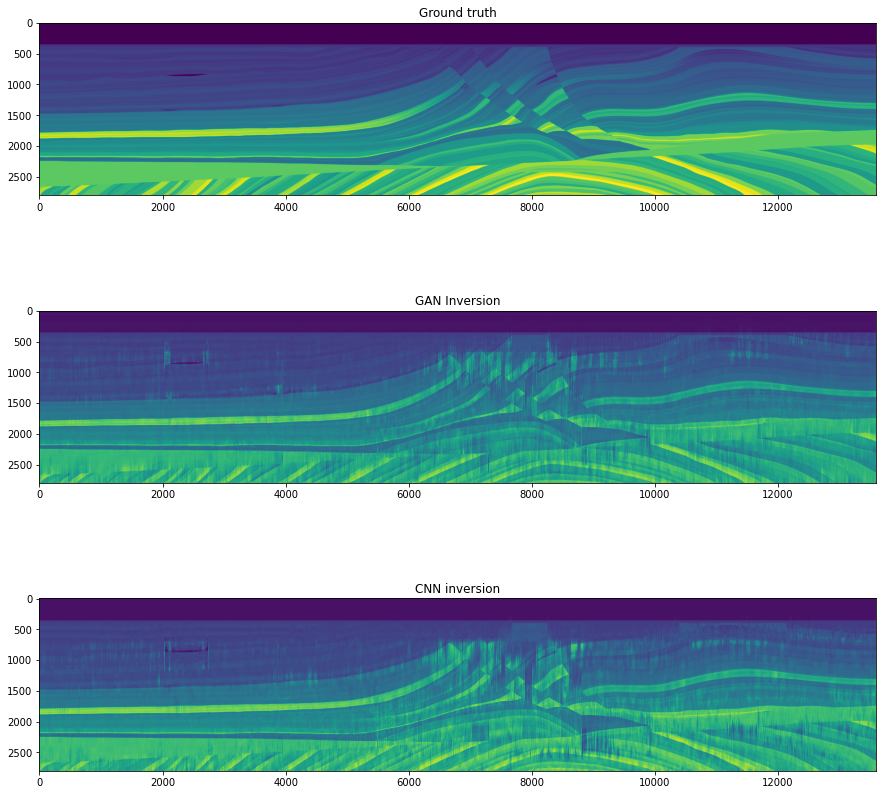

In [30]:
fig1, axes1 = plt.subplots(nrows=3, ncols=1, figsize=(15,15))
axes1[0].imshow(np.transpose(Y_test[:,:,0,0]))
axes1[0].set_title("Ground truth")

axes1[1].imshow(X_predict)
axes1[1].set_title("GAN Inversion")

axes1[2].imshow(X_predictCNN)
axes1[2].set_title("CNN inversion")

Text(0.5, 1.0, 'Trace No.: 9968')

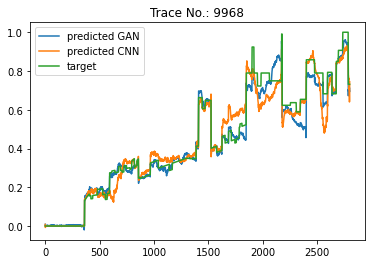

In [32]:
trace_id = np.random.randint(X_predict.shape[1])
plt.plot(X_predict[:,trace_id])
plt.plot(X_predictCNN[:,trace_id])
plt.plot(Y_test[trace_id,:,0])
plt.legend(('predicted GAN','predicted CNN','target'))
plt.title('Trace No.: '+str(trace_id))

# Train the same networks with Noisy Seismic

In [33]:
X_train_wNoise = X_train.copy()
X_valid_wNoise = X_valid.copy()
X_test_wNoise = X_test.copy()

noise_rate = 20

for it in range(X_train_wNoise.shape[0]):
    data_i = X_train_wNoise[it,:,0,0]
    noise_i = np.convolve(np.random.normal(size=(data_i.shape[0],)), WAVELET[:,0], mode='same')
    noise_i = noise_i/np.std(noise_i)
    noise_i = noise_i*np.std(data_i)/np.sqrt(noise_rate)
    
    data_i = data_i + noise_i
    X_train_wNoise[it,:,0,0] = data_i
    
for it in range(X_valid_wNoise.shape[0]):
    data_i = X_valid_wNoise[it,:,0,0]
    noise_i = np.convolve(np.random.normal(size=(data_i.shape[0],)), WAVELET[:,0], mode='same')
    noise_i = noise_i/np.std(noise_i)
    noise_i = noise_i*np.std(data_i)/np.sqrt(noise_rate)
    
    data_i = data_i + noise_i
    X_valid_wNoise[it,:,0,0] = data_i

for it in range(X_test_wNoise.shape[0]):
    data_i = X_test_wNoise[it,:,0,0]
    noise_i = np.convolve(np.random.normal(size=(data_i.shape[0],)), WAVELET[:,0], mode='same')
    noise_i = noise_i/np.std(noise_i)
    noise_i = noise_i*np.std(data_i)/np.sqrt(noise_rate)
    
    data_i = data_i + noise_i
    X_test_wNoise[it,:,0,0] = data_i

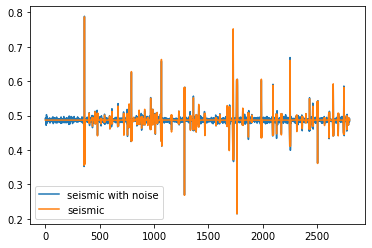

In [34]:
trace_id = np.random.randint(X_train.shape[0])
plt.plot(X_train_wNoise[trace_id,:,0,0])
plt.plot(X_train[trace_id,:,0,0])
plt.legend(('seismic with noise','seismic'))

### WGAN-GP with Noisy Seismic

In [35]:
# Initialize Callbacks
plot_losses_wnoise = PlotLosses()
checkp_callback_wnoise = keras.callbacks.ModelCheckpoint(filepath='best_model.hdf5',
                                             monitor='imp_loss',
                                             verbose=2,
                                             save_best_only=True,
                                             mode='min')

In [36]:
#Initialize internal models: 
g_model_wnoise = get_generator_model()
d_model_wnoise = get_discriminator_model()

#optimizers:
generator_optimizer_wnoise = keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer_wnoise = keras.optimizers.Adam(learning_rate = 0.001)

# All needed losses:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

def impedance_loss(fake_imp,real_imp):
    imp_mse = tf.keras.metrics.mean_squared_error(real_imp, fake_imp)
    return imp_mse

def seismic_loss(fake_seis,real_seis):
    seis_loss = tf.keras.metrics.mean_squared_error(real_seis, fake_seis)
    return seis_loss

wgan_wnoise = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=5,
    alpha_weight = 1000,
    beta_weight = 500,
    gp_weight = 10
)

wgan_wnoise.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
    imp_loss_fn = impedance_loss,
    seis_loss_fn = seismic_loss
)

In [37]:
wgan_wnoise.fit(X_train_wNoise,Y_train,
         shuffle=True,
         batch_size=BATCH_SIZE, 
         epochs=N_EPOCHS, 
         verbose = 1,
         #callbacks=[checkp_callback_wnoise]
        )

Epoch 1/2000
11/11 [==============================] - 20s 326ms/step - d_loss: -0.3304 - g_loss: 53.1968 - imp_loss: 2.1394 - seis_loss: 0.0990
Epoch 2/2000
11/11 [==============================] - 4s 325ms/step - d_loss: -0.4459 - g_loss: -41.0125 - imp_loss: 2.9806 - seis_loss: 0.0851
Epoch 3/2000
11/11 [==============================] - 4s 327ms/step - d_loss: -0.2833 - g_loss: -123.2966 - imp_loss: 2.4119 - seis_loss: 0.0741
Epoch 4/2000
11/11 [==============================] - 4s 324ms/step - d_loss: -0.2143 - g_loss: -124.9246 - imp_loss: 1.8743 - seis_loss: 0.0650
Epoch 5/2000
11/11 [==============================] - 4s 325ms/step - d_loss: -0.4722 - g_loss: 14.7774 - imp_loss: 1.9000 - seis_loss: 0.0553
Epoch 6/2000
11/11 [==============================] - 4s 325ms/step - d_loss: 0.0242 - g_loss: -166.3604 - imp_loss: 2.5679 - seis_loss: 0.0542
Epoch 7/2000
11/11 [==============================] - 4s 321ms/step - d_loss: 0.0166 - g_loss: -143.7810 - imp_loss: 2.6835 - seis_loss

In [59]:
X_predict_wnoise = np.zeros(Y_test.shape[0:2])
for i in range(round((X_predict_wnoise.shape[0])/1000)):
    start_,stop_ = (i*1000),(i+1)*1000
    if start_ >= X_predict_wnoise.shape[0]:
        start_ = X_predict_wnoise.shape[0]
    if stop_ >= X_predict_wnoise.shape[0]:
        stop_ = X_predict_wnoise.shape[0]    
        
    X_predict_wnoise[start_:stop_,:] = wgan_wnoise.generator(X_test_wNoise[start_:stop_,:,:,:])[:,:,0,0]
X_predict_wnoise = np.transpose(X_predict_wnoise)

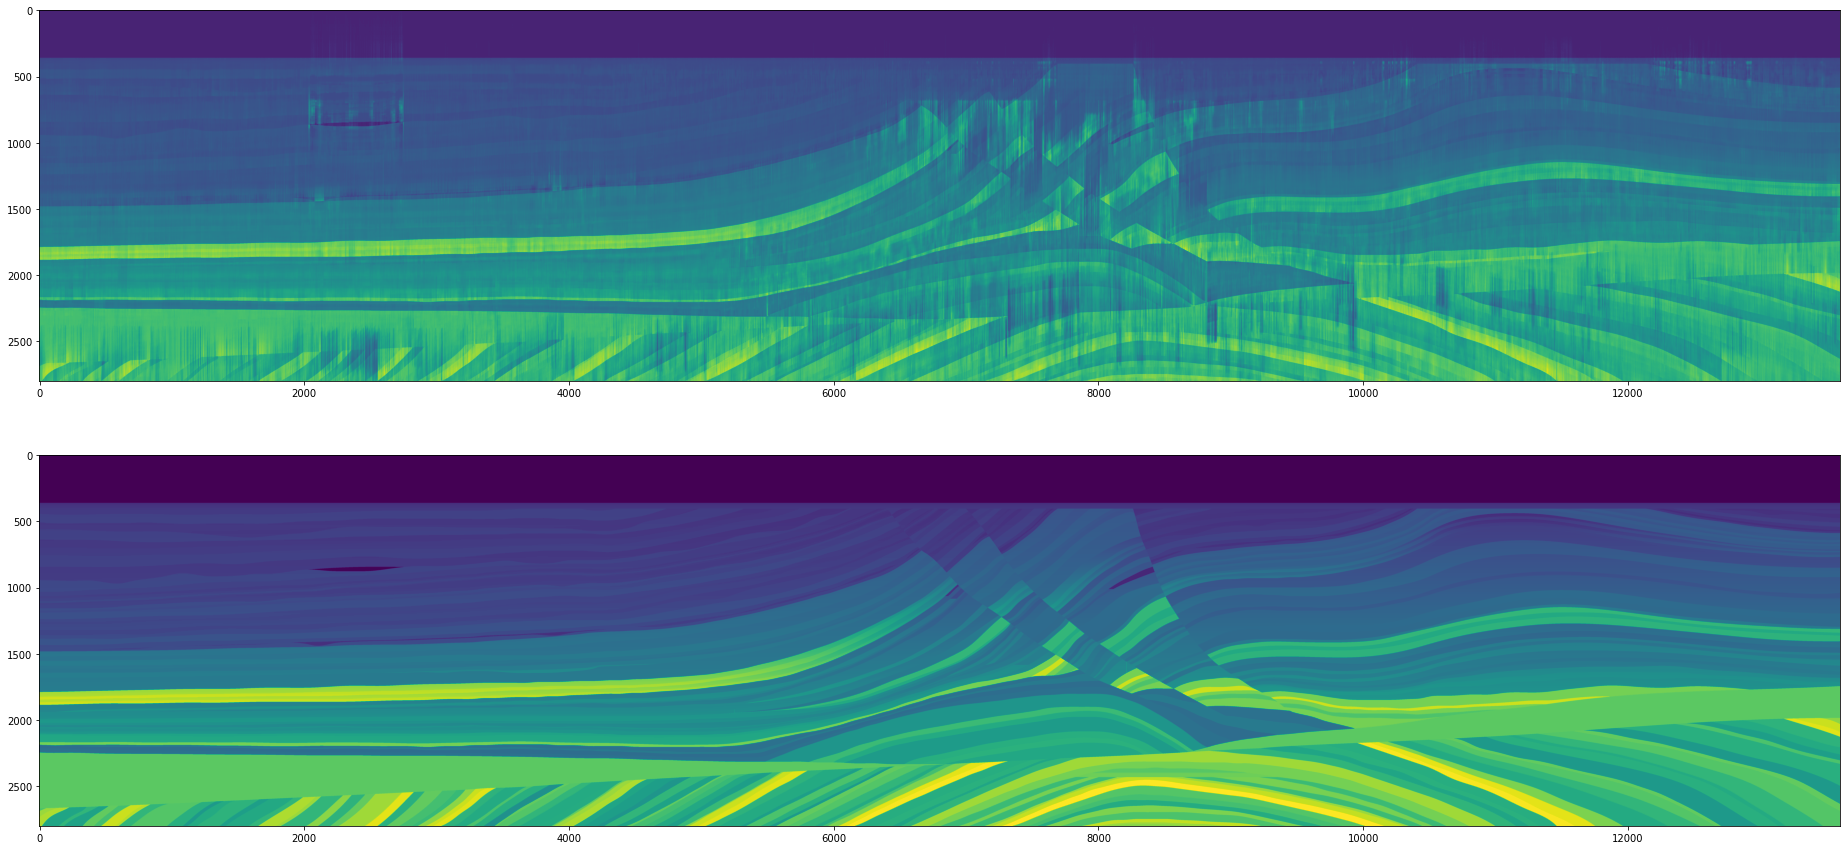

In [60]:
fig1, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(50,15))
axes1[0].imshow(X_predict_wnoise)
axes1[1].imshow(np.transpose(Y_test[:,:,0,0]))

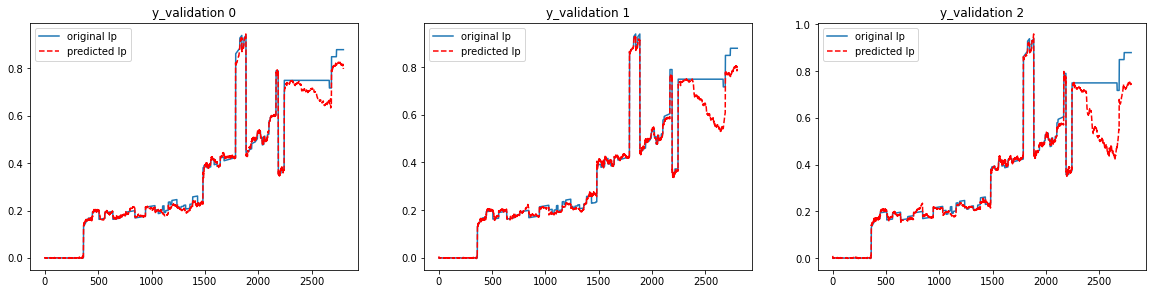

In [61]:
# trace_id = np.random.randint(X_predict.shape[1])
# plt.plot(X_predict_wnoise[:,trace_id])
# plt.plot(Y_test[trace_id,:,0])
# plt.legend(('predicted GAN with noise','target'))
# plt.title('Trace No.: '+str(trace_id))

n = 3
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    ax.set_title("y_validation {0}".format(i-1))
    plt.plot(Y_test[i-1, :, 0])
    plt.plot(X_predict_wnoise[:, i-1], '--r')
    plt.legend(['original Ip', 'predicted Ip'])
plt.show()

In [56]:
predict_image = X_predict_wnoise.flatten()
predict_image = (predict_image-np.min(predict_image))/(np.max(predict_image)-np.min(predict_image))
predict_image = predict_image.reshape(X_predict_wnoise.shape)
predict_image = (predict_image).astype('float32')

target_image = Y_test.flatten()
target_image = (target_image-np.min(target_image))/(np.max(target_image)-np.min(target_image))
target_image = target_image.reshape(Y_test[:,:,0,0].shape)
target_image = target_image.astype('float32')

SSIM = tf.image.ssim(target_image, predict_image, max_val=1).numpy()
#MSSIM = tf.image.ssim_multiscale(target_image, predict_image, max_val=1, power_factors=(0.0448, 0.2856, 0.3001, 0.2363)).numpy()
print('SSIM: ', SSIM)
#print('SSIM Multiscale: ', MSSIM)

fig1, axes1 = plt.subplots(nrows=1, ncols=2)
axes1[0].imshow(predict_image[:,:,0])
axes1[0].set_title("Predicted")
axes1[1].imshow(target_image[:,:,0])
axes1[1].set_title("Target")

(13601, 2800)
(13601, 2800)


ValueError: Shape (13601, 2800) must have rank at least 3

In [62]:
target_image_noise = Y_test[:,:,0,0].T
predict_image_noise = X_predict_wnoise[:,:]

mse_res_noise = tf.keras.metrics.mean_squared_error(target_image_noise.flatten(), predict_image_noise.flatten()).numpy()
mae_res_noise = tf.keras.metrics.mean_absolute_error(target_image_noise.flatten(), predict_image_noise.flatten()).numpy()

m_noise = tf.keras.metrics.RootMeanSquaredError()
m.update_state(target_image_noise.flatten(), predict_image_noise.flatten())

print("MSE: ", mse_res_noise)
print("MAE: ", mae_res_noise)
print("RMSE: ", m_noise.result().numpy())

MSE:  0.005109677564637227
MAE:  0.03990436295886609
RMSE:  0.0


### CNN Inversion with Noisy Seismic

In [ ]:
cnn_inversion_wnoise = get_generator_model()
optimizer_cnn_wnoise = keras.optimizers.Adam(learning_rate = 0.001)

cnn_inversion_wnoise.compile(optimizer=optimizer_cnn_wnoise, loss='mse', metrics='mse')
cnn_inversion_wnoise.fit(X_train_wNoise,Y_train, 
            validation_data=(X_valid_wNoise,Y_valid),
            epochs=N_EPOCHS,
            verbose=1,
            shuffle=True,
            batch_size=BATCH_SIZE,
           # callbacks = [plot_losses,checkpoint]
           )

In [ ]:
X_predictCNN_wnoise = np.zeros(Y_test.shape[0:2])
for i in range(round((X_predictCNN_wnoise.shape[0])/1000)):
    start_,stop_ = (i*1000),(i+1)*1000
    if start_ >= X_predictCNN_wnoise.shape[0]:
        start_ = X_predictCNN_wnoise.shape[0]
    if stop_ >= X_predictCNN_wnoise.shape[0]:
        stop_ = X_predictCNN_wnoise.shape[0]    
        
    X_predictCNN_wnoise[start_:stop_,:] = cnn_inversion_wnoise(X_test_wNoise[start_:stop_,:,:,:])[:,:,0,0]
X_predictCNN_wnoise = np.transpose(X_predictCNN_wnoise)   

In [ ]:
fig1, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(50,15))
axes1[0].imshow(X_predictCNN_wnoise)
axes1[1].imshow(np.transpose(Y_test[:,:,0,0]))

In [ ]:
trace_id = np.random.randint(X_predict.shape[1])
plt.plot(X_predict_wnoise[:,trace_id])
plt.plot(X_predictCNN_wnoise[:,trace_id])
plt.plot(Y_test[trace_id,:,0])
plt.legend(('predicted GAN with noise','predicted CNN with noise','target'))
plt.title('Trace No.: '+str(trace_id))